**Kaggle team name**: 🐧5-TheBeastCoin-Acosta,Yoo
1. Format: `🐧[BB Team#]-[Your fancy Kaggle group name]-[Students' names]`.
  1. Eg. `🐧A-Heros-Fleischer,Melnikov`, where 🐧 identifies JHU and `A` identifies the Canvas group code

Your private LB score must be reproducible with this Colab. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation). Don't exceed runtime quota.

<small><hr style="margin:0;background-color:silver"><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, ©<a href="https://apps.ep.jhu.edu/course-homepages/3765-605-742-deep-neural-networks" target="_blank">JHU</a> 2021 onwards</font></small>

<hr color=red>

# **🏆📈Crypto**


<details><summary><font color=darkblue>More info and Kaggle API instructions</font></summary>

[Kaggle competition URL](https://www.kaggle.com/competitions/4422crypto/rules). See competition rules, submission, grading, dataset, and performance metric. The **starter code** below produces a baseline model, which you should beat, while respecting the competition rules. Your code starts after the timer. This is your baseline model. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation) for reproducibility!

**Instructions for enabling Kaggle API in Colab**:
1. Accept competition rules before running [Kaggle API](https://github.com/Kaggle/kaggle-api#api-credentials). [Loading Kaggle dataset example](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab)
1. In your Kaggle Account, [Create API Token](https://github.com/Kaggle/kaggle-api#api-credentials) and save the resulting **kaggle.json** file to the [root of your Google Drive](https://drive.google.com/drive/u/0/my-drive)
2. In Colab, open **Files** panel 🗀 (on the left) and click gray folder icon <font color=gray>🖿</font> to mount your Google drive

Your Kaggle/Google Drive credentials are secure; and Colab's kaggle.json only lasts a Colab session.

</details>

## **Starter code (do not modify)**

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install tensorflow==2.8 > log
!apt -q install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 >> log
!pip -q install -U tfds-nightly tensorflow_addons tensorflow >> log

In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log       # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 4422crypto   # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log              # download competition dataset as a zip file
!unzip -o *.zip >> log                            # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 4422crypto
Using competition: 4422crypto
 teamId  teamName                            submissionDate       score    
-------  ----------------------------------  -------------------  -------  
8994273  Samuel Nathanson                    2022-08-15 00:36:55  0.58318  
8994218  David Na                            2022-08-15 02:28:44  0.51975  
8971975  🐧1-Hodl-Bollineni,Cahill,Riva       2022-08-15 02:25:58  0.47158  
8450081  J10E-TBD-Brodsky,Mendola            2022-04-17 21:29:47  0.43990  
8996485  🐧4-CoinCollector-Nguyen,Cui         2022-08-15 01:41:47  0.40280  
9006339  Naveen Sahi                         2022-08-14 01:16:46  0.39290  
9017049  🐧2-PonziPredictor-Nilla,Rice        2022-08-15 01:42:00  0.36672  
8484625  JD-NFToTheMoon-Hogge-Katsaros       2022-04-18 00:49:12  0.19944  
8996856  🐧5-TheBeastCoin-Acosta,Yoo          2022-08-14 22:59:26  0.17624  
8429302  JC-GoingBroke-Corson,Merran 

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla P100-PCIE-16GB, 16280 MiB, 11573 MiB, 4707 MiB


In [ ]:
!pip -q install -U tensorflow_addons > log   # update tfa in case students need to use it

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # We load it before tf. Still useless?  https://github.com/tensorflow/tensorflow/issues/38197
import tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, RNN, LSTM, TimeDistributed
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('max_columns', 20, 'precision', 2, 'display.max_rows', 4)

CPU times: user 387 ms, sys: 311 ms, total: 698 ms
Wall time: 713 ms


Your training data are 7 descriptive features for past 500K observations. See helpful [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition).

In [ ]:
tXY = pd.read_csv('tXY.csv', index_col='id'); tXY

Count  Open  High   Low  Close  Volume  VWAP
id                                                  
0          64  0.20  0.20  0.20   0.20     447  0.20
1          72  0.20  0.20  0.20   0.20     592  0.20
...       ...   ...   ...   ...    ...     ...   ...
499998   1636  1.15  1.16  1.15   1.15    2615  1.15
499999   3228  1.13  1.14  1.12   1.13    3354  1.13

[500000 rows x 7 columns]

Your task is to forecast the closing price for all future time steps (index IDs below).

In [ ]:
pY = pd.read_csv('sampleSubmission.csv', index_col='id'); pY.T

id     500000  500001  500002  500003  500004  500005  500006  500007  500008  \
Close       0       0       0       0       0       0       0       0       0   

id     500009  ...  524421  524422  524423  524424  524425  524426  524427  \
Close       0  ...       0       0       0       0       0       0       0   

id     524428  524429  524430  
Close       0       0       0  

[1 rows x 24431 columns]

In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer Start Here...</font></strong>


**TODO. Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

For this project the main components of our preprocessing was feature engineering and feature scaling. Based on the tutorial (see references) we decided to incoportate the upper shadow, lower shadow feature, as well as including the ratio of close to open. Ultimately we scaled our features using standardization and min-max scaling. For training purposes we used the last observations as our test set, while using the previous observations to this set as our training data.

*	<b>Evaluation:</b>
We have evaluated the effectiveness of our pre-processing by evaluating both the correlation on our in sample dataset as well as on our validation (out of sample) dataset. In addidition, we also used our kaggle submissions to evaluate the effectiveness of our preprocessing by comparing our scores in the leaderboard.

* <b>Things that worked/didn't work</b>
As noted earlier, the different scaling approaches did not show any improvements upon evaluating. The addition of the upper shadow, lower shadow , and close/open features did improve our correlation scores.

\

In [ ]:
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low
gain=lambda asset: asset.Close/asset.Open
tXY['upper_shadow']=tXY.apply(upper_shadow,axis=1)
tXY['lower_shadow']=tXY.apply(lower_shadow,axis=1)
tXY['gain']=tXY.apply(gain,axis=1)

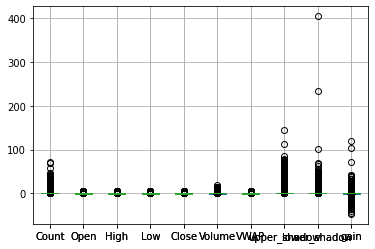

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler

ss=StandardScaler().fit(tXY)
df_s=pd.DataFrame(ss.transform(tXY),columns=tXY.columns);df_s.boxplot()
mms=MinMaxScaler().fit(df_s)
df_mms=pd.DataFrame(mms.transform(df_s),columns=df_s.columns);df_mms.boxplot()
tXY_og=tXY.copy()
tXY=df_mms
#rs=RobustScaler().fit(tXY)
#tXY=pd.DataFrame(rs.transform(tXY),columns=tXY.columns);tXY.boxplot()

In [ ]:
holdout_set=24431

In [ ]:
# fcast_size=10#int(len(pY)/8)#len(pY)#int(len(pY)/8)

In [ ]:
# fcast_size

In [ ]:
tXY_test=tXY.iloc[-1*holdout_set:,:].copy();tXY_test

Count  Open  High   Low  Close  Volume  VWAP  upper_shadow  \
475569  6.07e-03  0.56  0.55  0.56   0.56    0.03  0.56      1.69e-03   
475570  1.02e-02  0.56  0.55  0.56   0.56    0.05  0.56      2.03e-03   
...          ...   ...   ...   ...    ...     ...   ...           ...   
499998  3.58e-02  0.55  0.55  0.55   0.55    0.15  0.55      2.91e-02   
499999  7.17e-02  0.54  0.54  0.54   0.54    0.20  0.54      2.81e-02   

        lower_shadow  gain  
475569      7.46e-04  0.28  
475570      1.12e-03  0.28  
...              ...   ...  
499998      4.48e-03  0.26  
499999      8.21e-03  0.27  

[24431 rows x 10 columns]

In [ ]:
tXY_train=tXY.iloc[:-1*holdout_set,:].copy();tXY_train

Count  Open  High   Low  Close  Volume  VWAP  upper_shadow  \
0       3.16e-04  0.08  0.08  0.08   0.08    0.02  0.08      1.69e-03   
1       4.96e-04  0.08  0.08  0.08   0.08    0.03  0.08      1.02e-03   
...          ...   ...   ...   ...    ...     ...   ...           ...   
475567  6.72e-03  0.56  0.55  0.56   0.56    0.06  0.56      1.69e-03   
475568  5.43e-03  0.55  0.55  0.56   0.55    0.05  0.55      2.03e-03   

        lower_shadow  gain  
0           3.73e-04  0.28  
1           1.87e-04  0.28  
...              ...   ...  
475567      2.24e-03  0.28  
475568      9.33e-04  0.28  

[475569 rows x 10 columns]

In [ ]:
# fig,ax=plt.subplots(figsize=(30,5))
# #tXY.Close.plot()
# tXY_train.Close.plot()
# tXY_test.Close.plot()
# plt.axvline(len(tXY)-len(tXY_test))
# plt.axvline(len(tXY)-2*len(tXY_test))
# plt.axvline(len(tXY)-2*len(tXY_test)-20000)
# #plt.axvline(len(tXY)-len(tXY_test)-len(tXY_train)-20000)

**TODO. Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

We have tried different RNN models with tuning the hyperparameters to find the best model. We have monitored the scoring metric (Pearson R Correlation). We have finalized our model that gives the best score (and validation score) with acceptable risk of resource usage (GPU and RAM).

* <b> Evaluation:</b>

We used the Pearson R Correlation as our scoring metric because that is the requirement for this competition. We have calculated the corrleation between the actual value and the predicted one. Also, we have evaluated the running time (limit of 300 sec) of the code as well. We measured the execution time to check if the code can be run within the time limit. Also, since we are using huge dataset (500,000 points), handling the whole code within the capability of the hardware (RAM and GPU) is also very important. We also checked our code does not crash due to the lack of RAM size.

* <b> model selection</b>

For this assignment, we have tested two different RNN models (LSTM and GRU). Based on the observation, we found out that LSTM showed better performance than GRU. Therefore, we have decided to use LSTM as our final model.

* <b> Tuning hyper parameters </b>

The first thing we have tried is the tuning the hyper parameters (learning rate, number of neurons, number of layers, and number of epochs). Also, we decided to use GPU to accelerate the computation and we were able to reduce the running time within the time limit. We monitored the final score and tuned the hyper-parameters to give the best score. First, we gradually increased the number of neurons from 10 to 200. It helped up to 100 and showed the risk of overfitting at 200. So we have decided to use the number of neurons as 100. Surprisingly, increasing the number of layers was not helpful. The reason is because we are using RNN and this feeds back the output from one layer as an input for the next time stamp. So this may works similar to adding the multiple layers. In addition, once we train the lower layer, we already have the weights which is already trained. However, we need to train the upper layer from the scratch once the lower layer is trained at the initial epoch. Therefore, using large number of layers may not be helpful to increase the performance as we expected. We also tried to increase the number of epochs. We applied the callback and early stopping not to use the redundant time for already stabilized training.    

* <b> Changing optimizer</b>

From the textbook, it is recommended to find the best optimizer while tuning the hyperparameters. So we tried multiple optimizers (Adam, Adamgrad, Adamdelta, ftrl, and RMSProp) which are supported by Keras. Among these, Adam showed the best performance and we decided to use Adam as our optimizer.


* <b> Drop-out</b>

We have applied the drop-out to avoid the overfitting. We tried with and without the drop-out and checked the score from the validation set. Since we were not using many hidden layers, We were able to see there were not much difference and we decided not to use drop-out   

* <b> initializer</b>

Initialization would be helpful if we can get better score at the initial epoch. Based on our experiment, Glorot-Random intialization performed better than the Random-Normal or He-Normal initializer and we decided to use Glorot-Random initializer.

* <b> Application of 1D-conv layer</b>

As textbook suggested, adding 1D-convolutional layer would be helpful for improving the performance. However, we were able to see significant performance degradation after applying 1D-conv layer at the front. The reason is because 1D-conv layer breaks the causality. Since this is the prediction problem, it does not make sense if the future value contributes to the prediction of the current value. However, if we use the 1D-conv layer, already known future value may contribute to predict the current value. This may be helful for obtaining the good prediction score at the training. However, this will lead to the overfitting for sure. Therefore, using 1D-conv layer for this projecct is not recommended.

* <b> Sequence to Sequence vs Sequence to Vector </b>

Initially we made headway using the sequence to vector architecture. One of tricky parts in this project was implementing the sequence to sequence architecture given that for each time step the model is making a prediction the size of the target prediction. Given the GPU/RAM constraint of free colab, this severely limited the length of the training data that could be used to train our model. This limitation ultimately reformatted our approach to creating the training data, where we investigated through trial/failure to see how many samples/training size we could include without the system crashing. We found that using 50 samples of 100 observations would allow us to implement the seq2seq architecture, where the output sequence was of length 244431. Our evaluation indicated that this was not sufficient. Therefore we took the approach of forecasting at sparser intervals. We tried different combinations and ultimately settled on using 50 samples of 1000 observations each, forecasting every 5 points. For the points inbetween predictions we imputed this by fitting a cubic spline to the data and interpolating. This gave us our highest score on the leaderboard.

In [ ]:
# tXY_train

In [ ]:
# tXY_train=tXY_train.astype('float16')

In [ ]:
# Y=[]
# K=50
# Nx=10000
# for i in range(len(tXY)-len(tXY_test)-fcast_size-K,len(tXY)-len(tXY_test)-fcast_size):
#   sample=[]
#   for next_step in range(Nx):
#     s1=tXY.iloc[i+next_step:i+next_step+fcast_size]
#     sample.append(s1.Close.values)
#   Y.append(sample)

This is your baseline DNN model. Remember to [seed all your experiments](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) for reproducibility. [Status of GPU-Determinism in TF](https://github.com/NVIDIA/framework-determinism/blob/master/tensorflow_status.md).

In [ ]:
# K, (N, p), Nx, Ny = 50, tXY_train.shape, 20000, fcast_size  # samples, dataset dim, train set size, forecast set size
# LtX, LtY = [], []
# for i in range(N-Ny-K, N-Ny):                     # populate K samples with past X series and future Y series
#   LtX.append(tXY_train.iloc[(i-Nx):i, :].values)        # X: historical 7Dim observations for Nx steps behind
#   LtY.append(tXY_train.loc[i:(i+Ny-1),'Close'].values)  # Y: future closing prices for Ny steps ahead
# taX, taY = np.array(LtX), np.array(LtY)           # training arrays past input X and future output Y
# print(f'taX.shape=(K,Nx,p)={taX.shape}; taY=(K,Ny)={taY.shape}')  # convert to 3-tensors


# df = pd.DataFrame(np.r_[taX[0,:,4], taY[0,:]], columns=['train future price'])
# ax = df.plot(figsize=(30,3), title=f'Training series (before and after)- just a closing price series (out of K={K})');
# pd.DataFrame(taX[0,:,4], columns=['train past price']).plot(grid=True, ax=ax);


In [ ]:
%%time
K, (N, p), Nx, Ny,interval = 50, tXY_train.shape, 1000, len(pY),5  # samples, dataset dim, train set size, forecast set size
LtX, LtY = [], []
for i in range(N-Ny-K, N-Ny):                     # populate K samples with past X series and future Y series
  LtX.append(tXY_train.iloc[(i-Nx):i, :].values)        # X: historical 7Dim observations for Nx steps behind
  LtY_=[]
  for step_ahead in range(Nx):

    LtY_.append(tXY_og.loc[range((i-Nx+step_ahead),(i-Nx+step_ahead+Ny-1),interval),'Close'].values)  # Y: future closing prices for Ny steps ahead
    # if step_ahead==2:
    #   break
  LtY.append(np.array(LtY_))
  # break
  #LtY.append(tXY.loc[i:(i+Ny-1),'Close'].values)  # Y: future closing prices for Ny steps ahead

CPU times: user 53.3 s, sys: 752 ms, total: 54.1 s
Wall time: 55.1 s


In [ ]:
taX, taY = np.array(LtX), np.array(LtY)           # training arrays past input X and future output Y
print(f'taX.shape=(K,Nx,p)={taX.shape}; taY=(K,Num_predictions,Ny)={taY.shape}')  # convert to 3-tensors

taX.shape=(K,Nx,p)=(50, 1000, 10); taY=(K,Num_predictions,Ny)=(50, 1000, 4886)


In [ ]:

def last_time_step_corr(Y_true,Y_pred):
  return np.corrcoef(Y_true[:,-1],Y_pred[:,-1])#keras.metrics.mean_squared_error(Y_true[:,-1],Y_pred[:,-1])

Build an LSTM model with two hidden layers. It splits $K$ samples into batches with 7D series $X_{N_x\times p}$ as input and 1D series $Y_{N_y\times 1}$ as output.


In [ ]:
# %%time
# from keras.layers import TimeDistributed
# tf.random.set_seed(0)   # always seed your experiments
# Init = keras.initializers.GlorotUniform(seed=0) # seed all that you can

# m = Sequential(
#   [LSTM(10, return_sequences=True, input_shape=[None, p], name='LSTM1', kernel_initializer=Init, recurrent_initializer=Init),
#   TimeDistributed(Dense(Ny, name='out', kernel_initializer=Init)) ], name='RNN_model') # we build Ny forecasts
# m.summary()
# m.compile(optimizer='adam', loss='mean_squared_error')
# hist = m.fit(taX, taY, epochs=2, batch_size=1)

Let's see how it does on the insample evaluation

#10 Neuron (single LSTM Layer)


In sample evaluation

In [ ]:
# predicted_insample=m.predict(tXY_train.iloc[-len(pY)-Nx:-len(pY),:].values[np.newaxis,...])
# fig,ax=plt.subplots(figsize=(30,10))
# ax.plot(predicted_insample[0][-1],label='Predicted (inSample)')
# ax.plot(tXY_train.iloc[-len(pY):,:].Close.values,label='Actual')
# fig.legend()
# corr=np.corrcoef(predicted_insample[0][-1],tXY_train.iloc[-len(pY):,:].Close.values)
# ax.set_title(f"Insample: Pearson Correlation = {corr[0][1]:.4f}")

Out of sample evaluation

In [ ]:
# predicted=m.predict(tXY_train.iloc[-Nx:,:].values[np.newaxis,...])
# fig,ax=plt.subplots(figsize=(30,10))
# ax.plot(predicted[0][-1],label='Predicted')
# ax.plot(tXY_test.Close.values,label='Actual')
# fig.legend()
# corr=np.corrcoef(predicted[0][-1],tXY_test.Close.values)
# ax.set_title(f"Out of sample: Pearson Correlation = {corr[0][1]:.4f}")

In [ ]:
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [ ]:
# del m,predicted_insample,predicted
# gc.collect()

In [ ]:
taY.shape[-1]

4886

In [ ]:
valX=tXY_train.iloc[-Nx:,:].values[np.newaxis,...]

In [ ]:
range((N-Nx+step_ahead),(N-Nx+step_ahead+Ny-1),interval)

range(475568, 499998, 5)

In [ ]:
LtY_val=[]
for step_ahead in range(Nx):

  LtY_val.append(tXY_og.loc[range((N-Nx+step_ahead),(N-Nx+step_ahead+Ny-1),interval),'Close'].values)  # Y: future closing prices for Ny steps ahead
LtY_val=np.array(LtY_val);LtY_val.shape

(1000, 4886)

In [ ]:
valY=LtY_val[np.newaxis]

In [ ]:
valX.shape

(1, 1000, 10)

In [ ]:
valY.shape

(1, 1000, 4886)

In [ ]:
taX.shape,taY.shape

((50, 1000, 10), (50, 1000, 4886))

#100 Neuron (single LSTM Layer)

In [ ]:
%%time
from keras.layers import TimeDistributed
tf.random.set_seed(0)   # always seed your experiments
Init = keras.initializers.GlorotUniform(seed=0) # seed all that you can

es=keras.callbacks.EarlyStopping(monitor='val_last_time_step_corr',patience=20,restore_best_weights=True,mode='max')

def lr_scheduler_decay(epoch, lr):
    decay = 0.9
    return lr * decay

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_decay)

m = Sequential(
  [LSTM(100, return_sequences=True, input_shape=[None, p], name='LSTM1', kernel_initializer=Init, recurrent_initializer=Init),
   LSTM(100, return_sequences=True, input_shape=[None, p], name='LSTM2', kernel_initializer=Init, recurrent_initializer=Init),
  TimeDistributed(Dense(taY.shape[-1], name='out', kernel_initializer=Init)) ], name='RNN_model') # we build Ny forecasts
m.summary()
opt=keras.optimizers.Adam(learning_rate=.01)
m.compile(optimizer=opt, loss='mean_squared_error',metrics=[last_time_step_corr],run_eagerly=True)
hist = m.fit(taX, taY, epochs=128,validation_data=(valX,valY),batch_size=1,callbacks=[es,lr_decay_callback])
predicted_insample=m.predict(tXY_train.iloc[-Ny-Nx:-Ny,:].values[np.newaxis,...])

Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, None, 100)         44400     
                                                                 
 LSTM2 (LSTM)                (None, None, 100)         80400     
                                                                 
 time_distributed_5 (TimeDis  (None, None, 4886)       493486    
 tributed)                                                       
                                                                 
Total params: 618,286
Trainable params: 618,286
Non-trainable params: 0
_________________________________________________________________
Epoch 1/128
50/50 [==============================] - 4s 81ms/step - loss: 0.0650 - last_time_step_corr: 0.8884 - val_loss: 0.1046 - val_last_time_step_corr: 0.6822 - lr: 0.0090
Epoch 2/128
50/50 [==============================] - 4s 79ms/step - loss

In [ ]:
#np.max(hist.history['val_last_time_step_corr'])

In [ ]:
predicted_insample[0][-1]

array([0.76, 0.77, 0.77, 0.77, 0.78, ..., 1.16, 1.16, 1.16, 1.16, 1.15], dtype=float32)

In [ ]:
x=[interval*i for i in range(len(predicted_insample[0][-1]))]
from scipy.interpolate import CubicSpline
cs=CubicSpline(x,predicted_insample[0][-1])
new_y_insample=[cs(i) for i in range(np.max(x))]

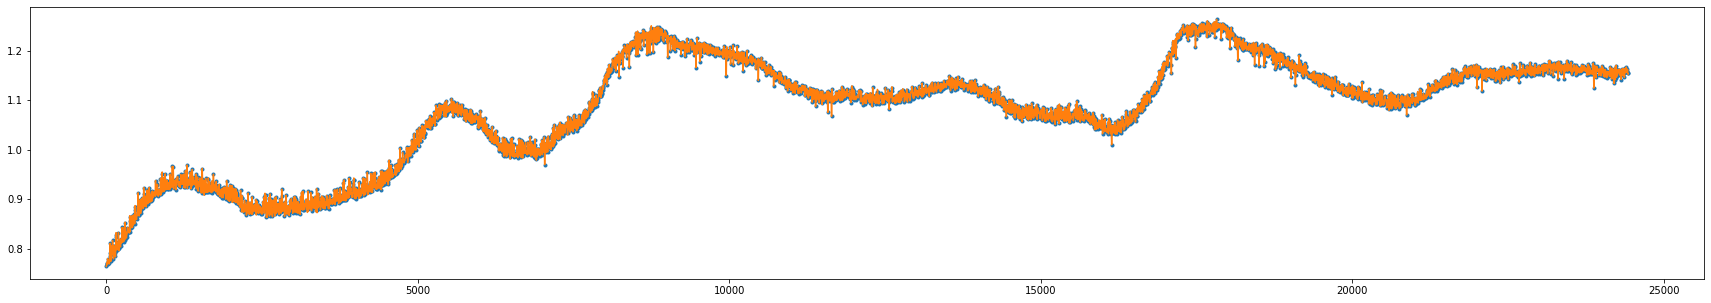

In [ ]:
fig,ax=plt.subplots(figsize=(30,5))
plt.plot(x,predicted_insample[0][-1],'.')
plt.plot(range(np.max(x)),new_y_insample)
#plt.xlim(5000,10000)

In [ ]:
remainder=len(pY)%len(new_y_insample);remainder

6

Text(0.5, 1.0, 'Insample: Pearson Correlation = 0.8738')

1/1 [==============================] - 0s 45ms/step


Text(0.5, 1.0, 'Out of sample: Pearson Correlation = 0.3650')

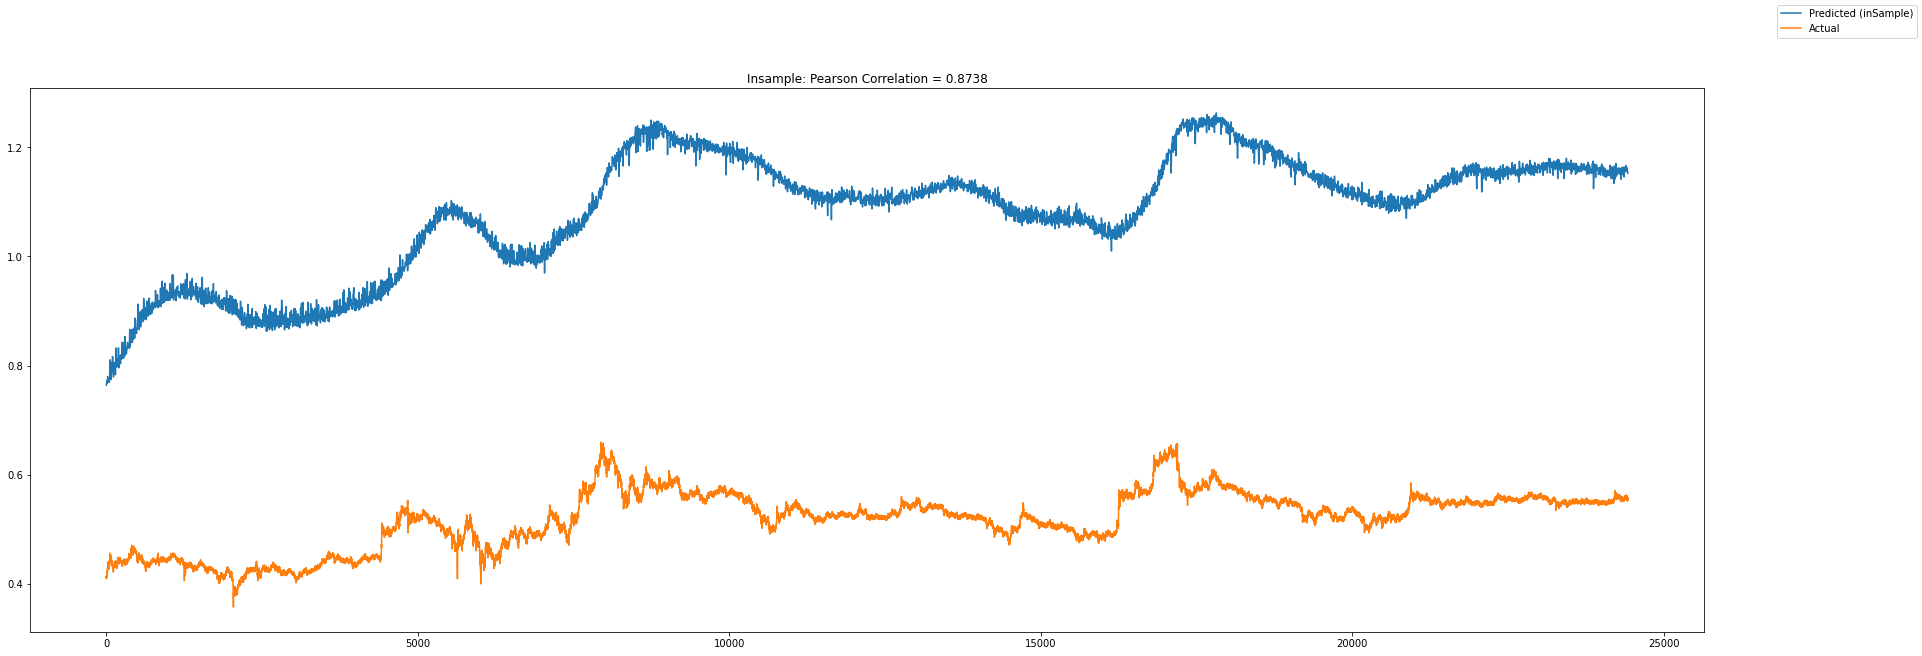

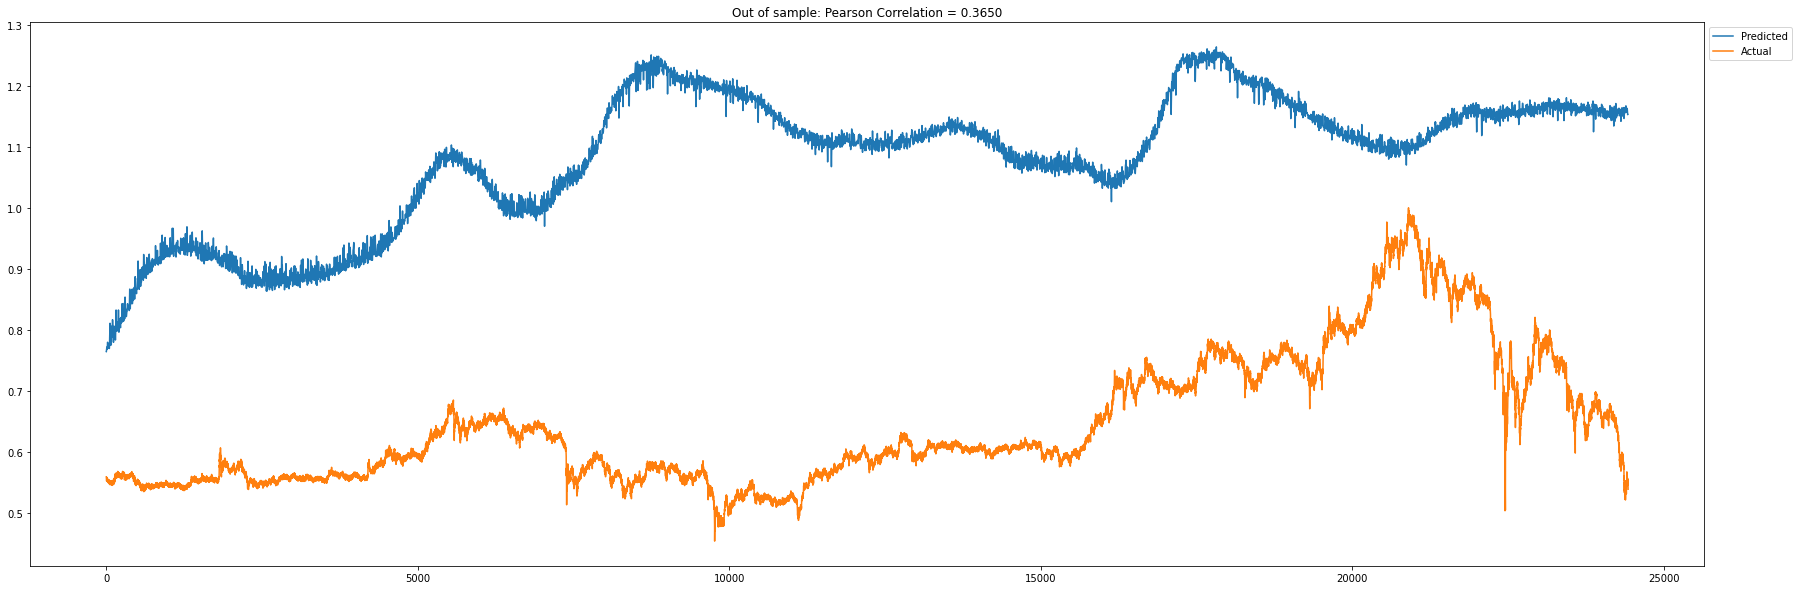

In [ ]:
fig,ax=plt.subplots(figsize=(30,10))
ax.plot(new_y_insample,label='Predicted (inSample)')
ax.plot(tXY_train.iloc[-Ny:,:].Close.values,label='Actual')
fig.legend()
corr=np.corrcoef(new_y_insample,tXY_train.iloc[-Ny+remainder:,:].Close.values)
ax.set_title(f"Insample: Pearson Correlation = {corr[0][1]:.4f}")
predicted=m.predict(tXY_train.iloc[-Nx:,:].values[np.newaxis,...])

x=[interval*i for i in range(len(predicted[0][-1]))]
cs=CubicSpline(x,predicted[0][-1])
new_y=[cs(i) for i in range(np.max(x))]


fig,ax=plt.subplots(figsize=(30,10))
ax.plot(new_y,label='Predicted')
ax.plot(tXY_test.Close.values,label='Actual')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
corr=np.corrcoef(new_y,tXY_test.Close.iloc[:-1*remainder].values)
ax.set_title(f"Out of sample: Pearson Correlation = {corr[0][1]:.4f}")

In [ ]:
# predicted_insample=m.predict(tXY_train.iloc[-Ny-Nx:-Ny,:].values[np.newaxis,...])
# fig,ax=plt.subplots(figsize=(30,10))
# ax.plot(predicted_insample[0][-1],label='Predicted (inSample)')
# ax.plot(tXY_train.iloc[-Ny:,:].Close.values,label='Actual')
# fig.legend()
# #corr=np.corrcoef(predicted_insample[0][-1],tXY_train.iloc[-Ny:,:].Close.values)
# #ax.set_title(f"Insample: Pearson Correlation = {corr[0][1]:.4f}")


In [ ]:
# predicted=m.predict(tXY_train.iloc[-Nx:,:].values[np.newaxis,...])
# fig,ax=plt.subplots(figsize=(30,10))
# ax.plot(predicted[0][-1],label='Predicted')
# ax.plot(tXY_test.Close.values,label='Actual')
# plt.legend(bbox_to_anchor=(1,1),loc='upper left')
# #corr=np.corrcoef(predicted[0][-1],tXY_test.Close.values)
# #ax.set_title(f"Out of sample: Pearson Correlation = {corr[0][1]:.4f}")

#200 Neuron (single LSTM Layer)

In [ ]:
# %%time
# from keras.layers import TimeDistributed
# tf.random.set_seed(0)   # always seed your experiments
# Init = keras.initializers.GlorotUniform(seed=0) # seed all that you can

# m = Sequential(
#   [LSTM(200, return_sequences=True, input_shape=[None, p], name='LSTM1', kernel_initializer=Init, recurrent_initializer=Init),
#   TimeDistributed(Dense(Ny, name='out', kernel_initializer=Init)) ], name='RNN_model') # we build Ny forecasts
# m.summary()
# m.compile(optimizer='adam', loss='mean_squared_error')
# hist = m.fit(taX, taY, epochs=2, batch_size=1)
# predicted_insample=m.predict(tXY_train.iloc[-len(pY)-Nx:-len(pY),:].values[np.newaxis,...])
# fig,ax=plt.subplots(figsize=(30,10))
# ax.plot(predicted_insample[0][-1],label='Predicted (inSample)')
# ax.plot(tXY_train.iloc[-len(pY):,:].Close.values,label='Actual')
# fig.legend()
# corr=np.corrcoef(predicted_insample[0][-1],tXY_train.iloc[-len(pY):,:].Close.values)
# ax.set_title(f"Insample: Pearson Correlation = {corr[0][1]:.4f}")
# predicted=m.predict(tXY_train.iloc[-Nx:,:].values[np.newaxis,...])
# fig,ax=plt.subplots(figsize=(30,10))
# ax.plot(predicted[0][-1],label='Predicted')
# ax.plot(tXY_test.Close.values,label='Actual')
# plt.legend(bbox_to_anchor=(1,1),loc='upper left')
# corr=np.corrcoef(predicted[0][-1],tXY_test.Close.values)
# ax.set_title(f"Out of sample: Pearson Correlation = {corr[0][1]:.4f}")

The plot below: the model memorized the prices from recent history (plus some local noise). Still you can use these predictions to visually (i.e. qualitatively) determine whether predictions are meaningful (i.e. have price-like shape) or just noise.

In [ ]:
tX_recent = tXY.iloc[-Nx:,:]  # most recent history of the coin
predicted = m.predict(tX_recent.values[np.newaxis,...]) # the model expects a 3-tensor (K=1,Nx,p)

x=[interval*i for i in range(len(predicted[0][-1]))]
cs=CubicSpline(x,predicted[0][-1])
new_y=[cs(i) for i in range(np.max(x))]

1/1 [==============================] - 0s 47ms/step


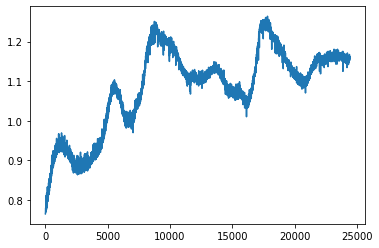

In [ ]:
plt.plot(new_y)

In [ ]:
final_y=np.array(new_y+remainder*[new_y[-1]])

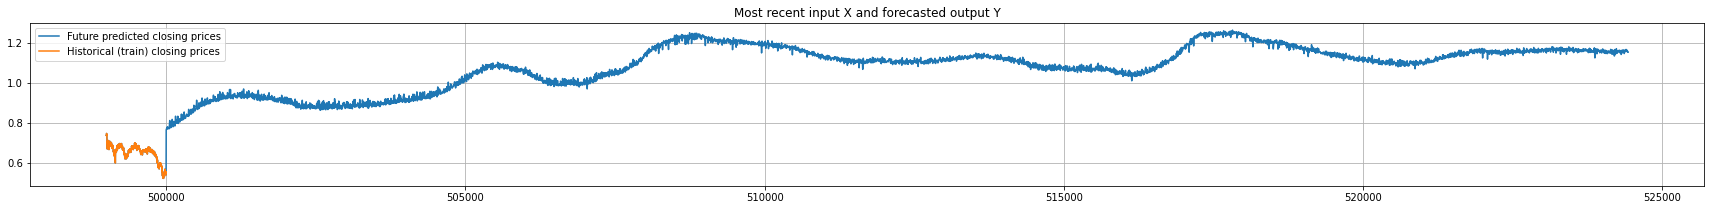

In [ ]:
#tX_recent = tXY.iloc[-Nx:,:]  # most recent history of the coin
pY['Close'] = final_y#m.predict(tX_recent.values[np.newaxis,...])[0][-1].flatten()  # the model expects a 3-tensor (K=1,Nx,p)
ax = pd.concat([tX_recent.Close, pY.Close]).plot(figsize=(30,3), title='Most recent input X and forecasted output Y');
tX_recent.Close.plot(ax=ax, grid=True);
ax.legend(["Future predicted closing prices", "Historical (train) closing prices"]);

1. The model generates a baseline submission CSV file, see Colab folder (🗀 on the left).
1. You can download the generated CSV file and submit it to Kaggle.

In [ ]:
ToCSV(pY, 'latest_sub_interpolating_10_return_sequence_preproceesing_using_min_max_std_new_feat')

# **References:**

1. https://keras.io/api/optimizers/
2. https://keras.io/api/layers/activations/
3. Géron, A. (2019). Hands-on machine learning with scikit-learn, keras, and tensorflow: Concepts, tools, and techniques to build intelligent systems (2nd edition). O'Reilly Media
4. https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition


<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 264 sec


# 💡**Starter Ideas**

1. Try different RNN architectures and hyperparameters
1. Try [correlation loss/metric](https://duckduckgo.com/?q=correlation+loss+in+tensorflow&ia=web) (or equivalent)
1. Try longer/shorter history. FYI: GPU may not fit all observations, but you could lower the precision or simplify DNN
1. Try forecasting returns (differences or log differences at different lags) instead of actual values. Returns might appear "more" stationary (You'll need to compute forecasted prices from forecasted returns later)
1. Try new features: differences, fractions, powers of existing features, lagged features or lagged differences,..
1. Try a different time scale. Eg. forecasting every $k$ steps and then imputing interim values
1. Try technique in HOML pp.509-510
1. Try (programmatically) assigning higher/lower weights to history or historical events (such as extreme events)
1. Check [Kaggle G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting/code) competition for more suitable ideas.
1. Try further smoothing/averaging and forecasting values at sparser intervals
1. Try forecasting just the future trend